In [ ]:
!pip -q install monai gdown einops mlflow pynrrd torchinfo 
!pip install pandas numpy nibabel tqdm
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
print(len(train_images))
print(len(train_images2))
print(len(train_labels))

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
# for check_data in check_loader:
#     print(check_data[0]['image'].shape)
#     print(check_data[0]['label'].shape)
#     break
# image, label = (check_data["image"][0][0], check_data["label"][0][0])
# print(f"image shape: {image.shape}, label shape: {label.shape}")
check_data = check_ds[8]
print(check_data['image'].meta[ImageMetaKey.FILENAME_OR_OBJ])
plt.figure("image", (6, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(check_data["image"][i, :, :, 150].detach().cpu())
plt.show()
plt.figure("image", (6, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(check_data["image2"][i, :, :, 150].detach().cpu())
plt.show()
plt.figure("label", (6, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(check_data["label"][i, :, :, 122].detach().cpu())
plt.show()

In [ ]:
print(len(train_files))
print(len(val_files))
print(len(test_files))

In [ ]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
# for check_data in check_loader:
#     print(check_data[0]['image'].shape)
#     print(check_data[0]['label'].shape)
#     break
# image, label = (check_data["image"][0][0], check_data["label"][0][0])
# print(f"image shape: {image.shape}, label shape: {label.shape}")
check_data = check_ds[2]
# print(check_data['image'].meta[ImageMetaKey.FILENAME_OR_OBJ])
plt.figure("image", (6, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(check_data["image"][i, :, :, 90].detach().cpu())
plt.show()
plt.figure("image", (6, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(check_data["image2"][i, :, :, 150].detach().cpu())
plt.show()
plt.figure("label", (6, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(check_data["label"][i, :, :, 97].detach().cpu())
plt.show()

In [ ]:
check_ds = Dataset(data=train_files, transform=orig_transforms)
check_loader = DataLoader(check_ds, batch_size=1)

In [ ]:
check_data = check_ds[2]
label = check_data['label']

In [ ]:
np.count_nonzero(label == 0)

In [ ]:
check_data = check_ds[0]
print(check_data['image'].meta[ImageMetaKey.FILENAME_OR_OBJ])
plt.figure("image", (6, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(check_data["image"][:, :, 150].detach().cpu())
plt.show()
plt.figure("image", (6, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(check_data["image2"][:, :, 150].detach().cpu())
plt.show()
plt.figure("label", (12, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(check_data["label"][i, :, :, 97].detach().cpu())
plt.show()

In [1]:
import os
from glob import glob
import shutil
import tempfile
import time
import warnings
import torch
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from collections.abc import Callable, Sequence, Hashable
from typing import Mapping,Dict
import matplotlib.pyplot as plt

from monai.transforms import (
    EnsureType,
    FillHoles,
    OneOf,
    SpatialCropd,
    Activations,
    Activationsd,
    ConcatItemsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    RandAffined,
    NormalizeIntensityd,
    ToTensord,
    EnsureChannelFirstd ,
    Orientationd,
    Spacingd,
    ScaleIntensityRanged,
    CropForegroundd,
    NormalizeIntensityd,
    Resized,
    SaveImaged,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    RandSpatialCropSamplesd,
    RandFlipd,
    RandRotated,
    EnsureTyped,
    ScaleIntensityd,
    RandCropByPosNegLabeld,
)

from monai.apps import DecathlonDataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss, DiceCELoss, DeepSupervisionLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.nets import SegResNet, SegResNetDS
from monai.data import Dataset, DataLoader, CacheDataset, decollate_batch
from monai.utils import first
from monai.utils import set_determinism
from monai.config import print_config
from monai.data.meta_tensor import MetaTensor
from monai.config.type_definitions import NdarrayOrTensor
from monai.utils.misc import ImageMetaKey

/WAVE/users/unix/smalladi/.conda/envs/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/WAVE/users/unix/smalladi/.conda/envs/venv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/WAVE/users/unix/smalladi/.conda/envs/venv/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
set_determinism(seed=123)

root_dir = '/WAVE/users/unix/smalladi/varian_ml/Hecktor22'
data_dir = 'hecktor2022_training/hecktor2022'
resampled_ct_path = '/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/hecktor2022/resampled_largerCt'
resampled_pt_path = '/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/hecktor2022/resampled_largerPt'
resampled_label_path = '/WAVE/users/unix/smalladi/varian_ml/hecktor2022_training/hecktor2022/resampled_largerlabel'

train_images = sorted(
    glob(os.path.join(resampled_ct_path, "*_CT*")))
train_images2 = sorted(
    glob(os.path.join(resampled_pt_path, "*_PT*")))
train_labels = sorted(
    glob(os.path.join(resampled_label_path, "*.nii.gz")))
data_dicts = [{"image": image_name, "image2": pet_image, 'label': label_name}
    for image_name, pet_image, label_name in zip(train_images, train_images2, train_labels)
]
len(data_dicts)

import random
x=[i for i in range(488)]
# print(x)
random.shuffle(x)
# print(x)
train_index,val_index,test_index=x[:400],x[400:480],x[480:]
train_files=[]
val_files=[]
test_files=[]
for i in train_index:
    train_files.append(data_dicts[i])
for i in val_index:
    val_files.append(data_dicts[i])
for i in test_index:
    test_files.append(data_dicts[i])
    
ct_a_min = -200
ct_a_max = 400
pt_a_min = 0
pt_a_max = 25
crop_samples = 2
input_size = [96, 96, 96]
modes_2d = ['bilinear', 'bilinear', 'nearest']
p = 0.5
strength = 1
image_keys = ["image", "image2", "label"]
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "image2", "label"]),
        EnsureChannelFirstd(keys = ["image", "image2", "label"]),
        Orientationd(keys=["image", "image2", "label"], axcodes="RAS"),
        Spacingd(
            keys=image_keys,
            pixdim=(1, 1, 1),
            mode=modes_2d,
        ),
        ScaleIntensityRanged(keys=['image'], a_min=ct_a_min, a_max=ct_a_max, b_min=0.0, b_max=1.0, clip=True),
        ScaleIntensityRanged(keys=['image2'], a_min=pt_a_min, a_max=pt_a_max, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=image_keys, source_key='image'),
        RandCropByPosNegLabeld(
            keys=image_keys,
            label_key='label',
            spatial_size=input_size,
            pos=1,
            neg=1,
            num_samples=crop_samples,
            image_key='image',
            image_threshold=0,
        ),
        RandAffined(keys=image_keys, prob=p,
                    translate_range=(round(10 * strength), round(10 * strength), round(10 * strength)),
                    padding_mode='border', mode=modes_2d),
        RandAffined(keys=image_keys, prob=p, scale_range=(0.10 * strength, 0.10 * strength, 0.10 * strength),
                    padding_mode='border', mode=modes_2d),
        RandFlipd(keys=["image", "image2", "label"], prob=p/3, spatial_axis=0),
        RandFlipd(keys=["image", "image2", "label"], prob=p/3, spatial_axis=1),
        RandFlipd(keys=["image", "image2", "label"], prob=p/3, spatial_axis=2),
        RandShiftIntensityd(
            keys=["image", "image2"],
            offsets=0.10,
            prob=p,
        ),
        ToTensord(keys=["image", "image2", "label"])
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "image2", "label"]),
        EnsureChannelFirstd(keys = ["image", "image2", "label"]),
        Orientationd(keys=["image", "image2", "label"], axcodes="RAS"),
        Spacingd(
            keys=image_keys,
            pixdim=(1, 1, 1),
            mode=modes_2d,
        ),
        ScaleIntensityRanged(keys=['image'], a_min=ct_a_min, a_max=ct_a_max, b_min=0.0, b_max=1.0, clip=True),
        ScaleIntensityRanged(keys=['image2'], a_min=pt_a_min, a_max=pt_a_max, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=image_keys, source_key='image'),
        ToTensord(keys=["image", "image2", "label"])
    ]
)

orig_transforms = Compose(
    [
        LoadImaged(keys=["image", "image2", "label"]),
        # ConvertToMultiChannelBasedOnClassesd(keys='label'),
    ]
)       

IndexError: list index out of range

In [2]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.0,
    num_workers=2)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=0.0,
    num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

In [3]:
train_ds[5]['label'].shape

torch.Size([1, 192, 192, 192])

In [4]:
max_epochs = 1
val_interval = 1
VAL_AMP = True
lr = 0.0002
momentum = 0
sigmoid = False
weight_decay = 1.0e-05
T_0 = 40
n_classes = 3
input_size = (96, 96, 96)
# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNetDS(
    blocks_down=[1, 2, 2, 4, 4],
    init_filters=32,
    in_channels=2,
    norm = 'batch',
    out_channels= n_classes,
    dsdepth=4,
).to(device)
# loss_function = DiceLoss(include_background=False, to_onehot_y=False, sigmoid=True)
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# # Scheduler
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=T_0, T_mult=1, eta_min=1e-8)
# dice_metric = DiceMetric(include_background=False, reduction='mean', get_not_nans=False)
# dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(softmax=True), AsDiscrete(threshold=0.5, to_onehot=n_classes)])
# post_label = AsDiscrete(to_onehot=n_classes)
# post_pred = AsDiscrete(argmax=True, to_onehot=n_classes)
loss_function = DiceCELoss(include_background = True, smooth_nr=0, smooth_dr=1e-5, squared_pred=True, 
                           to_onehot_y=True, sigmoid=False, softmax = True)
loss_function = DeepSupervisionLoss(loss_function)
optimizer = torch.optim.AdamW(model.parameters(), lr = lr, weight_decay=1e-5)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=T_0,
                                                                     # T_mult=1, eta_min=1e-8)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
# post_pred = Compose([AsDiscrete(argmax=True, to_onehot=n_classes)])
# post_label = Compose([AsDiscrete(to_onehot=n_classes)])
# post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=input_size,
            sw_batch_size=4,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [5]:
!nvidia-smi

Fri Aug 25 11:31:25 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB            Off| 00000000:3B:00.0 Off |                    0 |
| N/A   32C    P0               36W / 250W|    806MiB / 32768MiB |     17%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_1 = []
metric_values_2 = []
total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputsct, inputspt, labels = (
            batch_data['image'].as_subclass(torch.Tensor).to(device),
            batch_data['image2'].as_subclass(torch.Tensor).to(device),
            batch_data['label'].as_subclass(torch.Tensor).to(device),
        )
        inputs = torch.concat([inputsct, inputspt], axis=1)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        # loss.backward()
        scaler.step(optimizer)
        # optimizer.step()
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    # lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for val_data in val_loader:
                val_inputsct, val_inputspt, val_labels = (
                    val_data['image'].to(device),
                    val_data['image2'].to(device),
                    val_data['label'].to(device),
                )
                val_inputs = torch.concat([val_inputsct, val_inputspt], axis=1)
                val_outputs = inference(val_inputs)
                loss = loss_function(val_outputs, val_labels)
                val_loss += loss.item()
                # val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                # val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # val_outputs = sliding_window_inference(val_inputs, input_size, 4, model)
                # val_label_list = decollate_batch(val_label)
                # val_label_convert = [post_label(val_label_tensor) for val_label_tensor in val_label_list]
                # val_outputs_list = decollate_batch(val_outputs)
                # val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                # dice_metric(y_pred=val_output_convert, y=val_label_convert)
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)
            print(f"val loss: {val_loss}")
            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_1 = metric_batch[0].item()
            metric_values_1.append(metric_1)
            metric_2 = metric_batch[1].item()
            metric_values_2.append(metric_2)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" 1: {metric_1:.4f} 2: {metric_2:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/1
1/400, train_loss: 3.4121, step time: 27.5704
2/400, train_loss: 2.1992, step time: 0.5411
3/400, train_loss: 1.8161, step time: 0.6123
4/400, train_loss: 1.5533, step time: 0.5575
5/400, train_loss: 1.5061, step time: 0.6047
6/400, train_loss: 1.3362, step time: 0.5515
7/400, train_loss: 1.3419, step time: 0.5760
8/400, train_loss: 1.3237, step time: 0.6389
9/400, train_loss: 1.3493, step time: 0.5614
10/400, train_loss: 1.2774, step time: 0.6679
11/400, train_loss: 1.3395, step time: 0.5867
12/400, train_loss: 1.3060, step time: 0.6451
13/400, train_loss: 1.3537, step time: 0.5420
14/400, train_loss: 1.3065, step time: 0.5784
15/400, train_loss: 1.3087, step time: 0.5412
16/400, train_loss: 1.4670, step time: 0.5556
17/400, train_loss: 1.5568, step time: 0.5544
18/400, train_loss: 1.8219, step time: 0.5740
19/400, train_loss: 1.7938, step time: 0.5470
20/400, train_loss: 1.2744, step time: 0.5683
21/400, train_loss: 1.2577, step time: 0.5708
22/400, train_loss: 1

../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [3998,0,0], thread: [28,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.


RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR

In [ ]:
import gc
gc.collect()

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Val Mean Dice : 1")
x = [val_interval * (i + 1) for i in range(len(metric_values_1))]
y = metric_values_1
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice : 2")
x = [val_interval * (i + 1) for i in range(len(metric_values_2))]
y = metric_values_2
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.show()

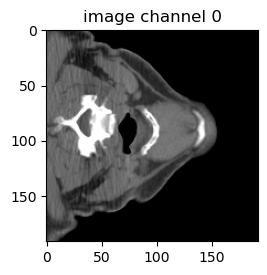

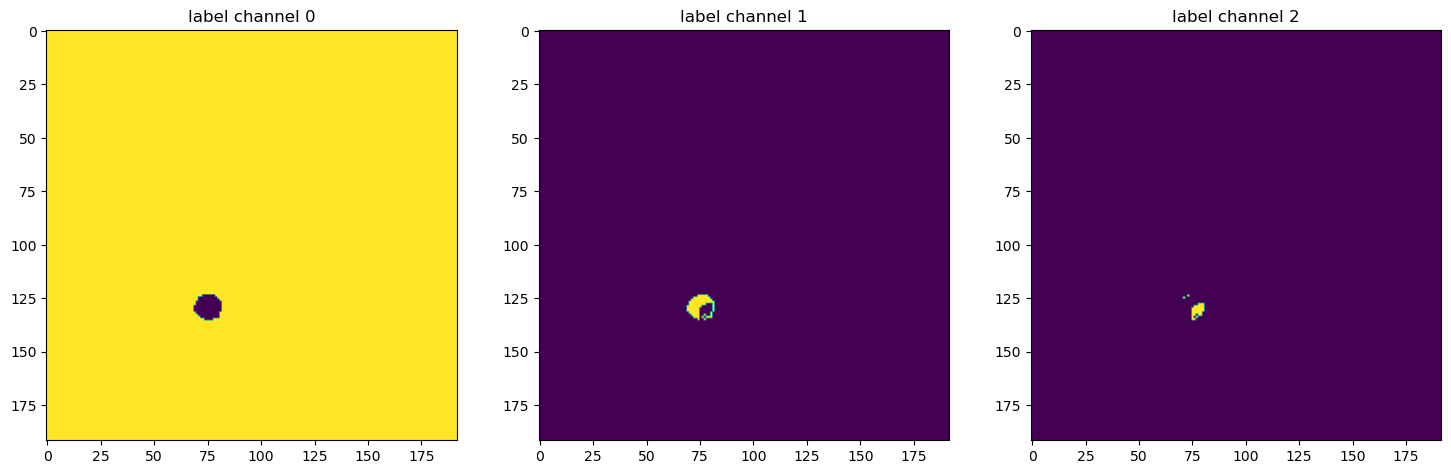

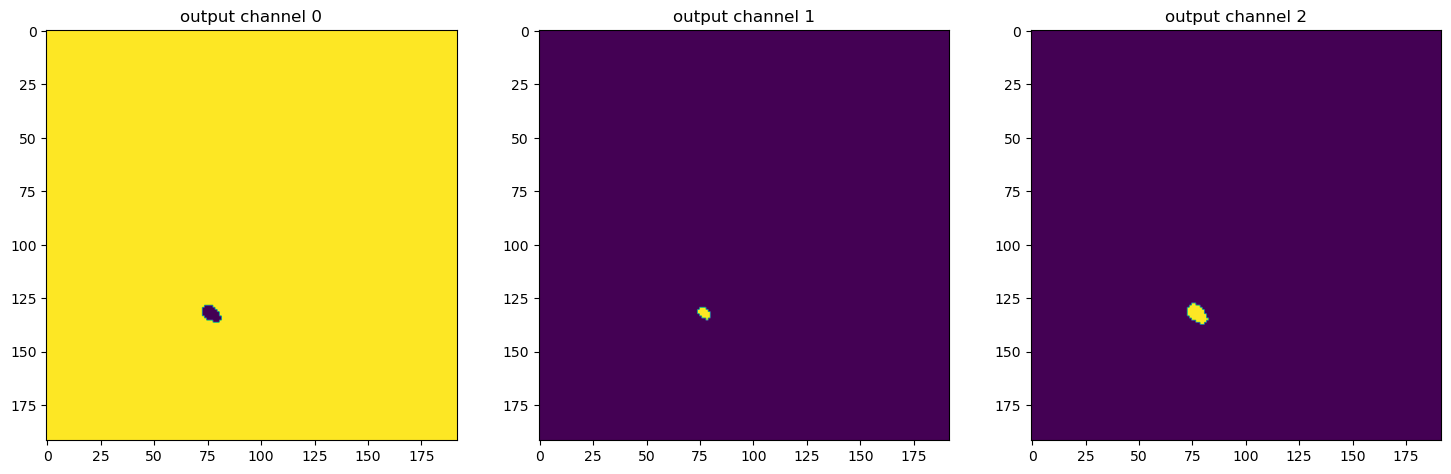

In [5]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_inputct = val_ds[5]["image"].unsqueeze(0).to(device)
    val_inputpt = val_ds[5]["image2"].unsqueeze(0).to(device)
    val_input = torch.concat([val_inputct, val_inputpt], axis=1)
    roi_size = (192, 192, 192)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (6, 6))
    for i in range(1):
        plt.subplot(1, 2, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[5]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[5]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

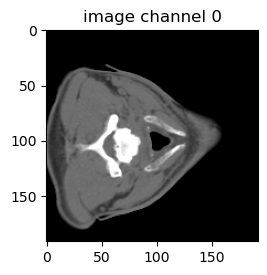

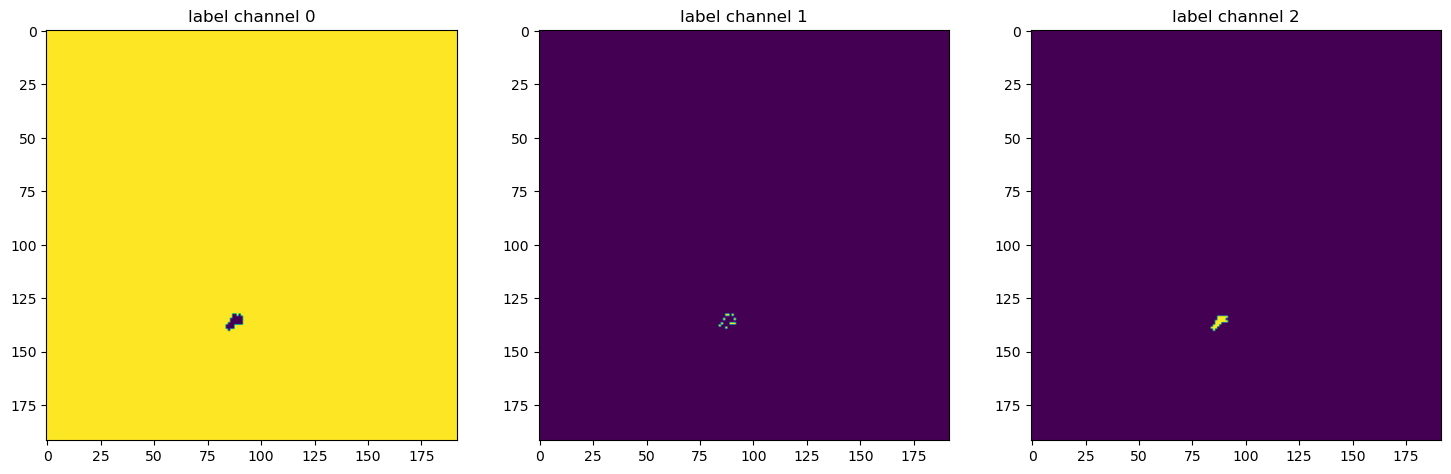

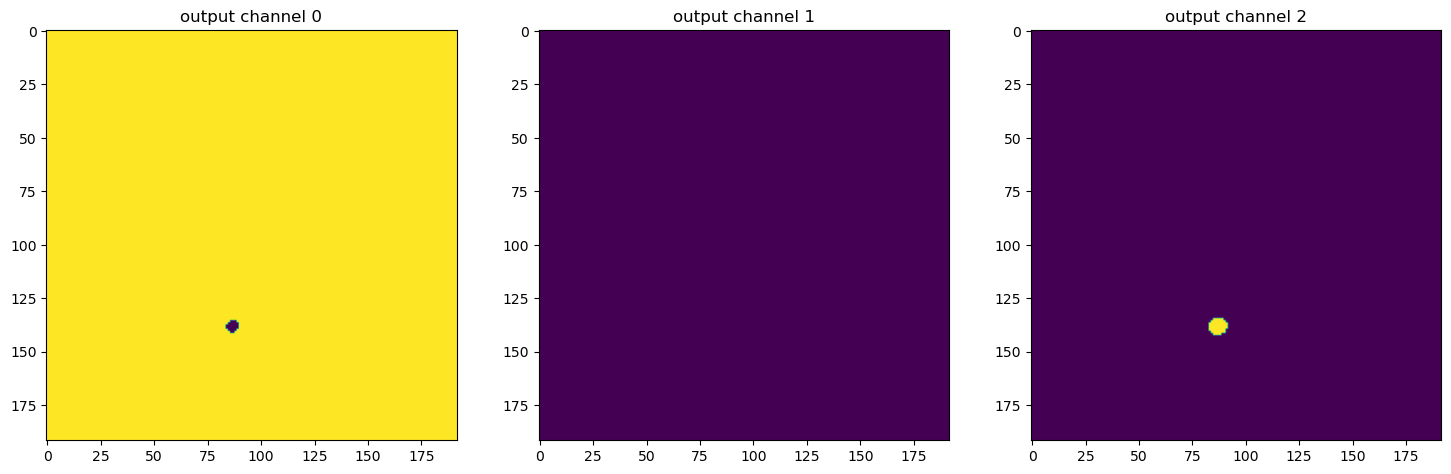

In [6]:
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_inputct = val_ds[7]["image"].unsqueeze(0).to(device)
    val_inputpt = val_ds[7]["image2"].unsqueeze(0).to(device)
    val_input = torch.concat([val_inputct, val_inputpt], axis=1)
    roi_size = (192, 192, 192)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (6, 6))
    for i in range(1):
        plt.subplot(1, 2, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[7]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[7]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

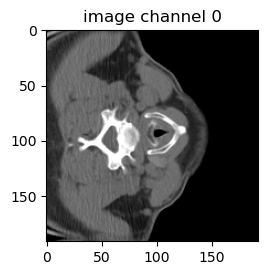

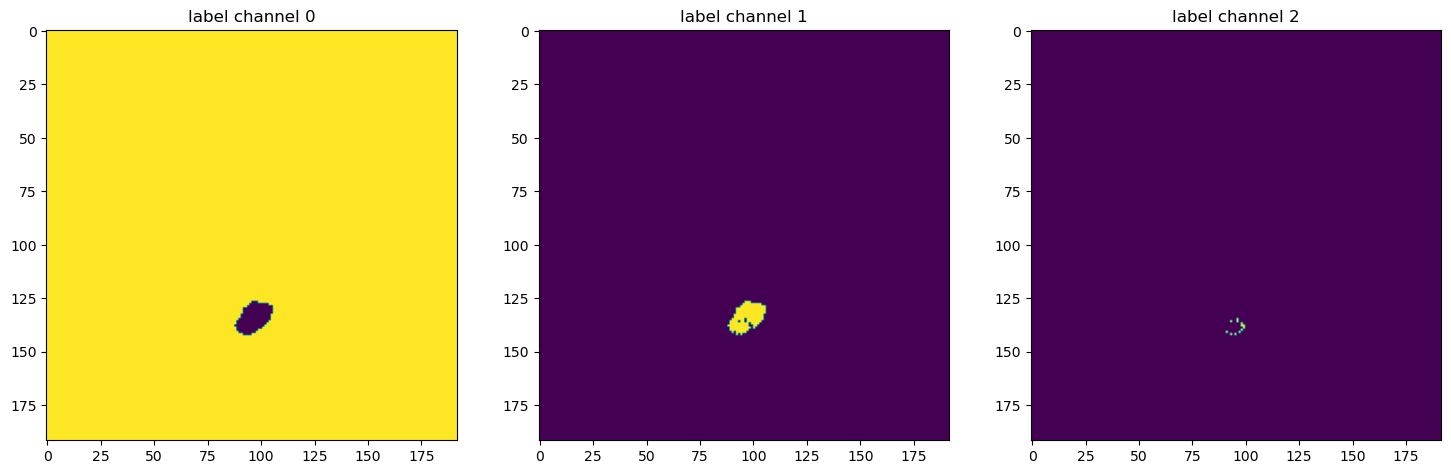

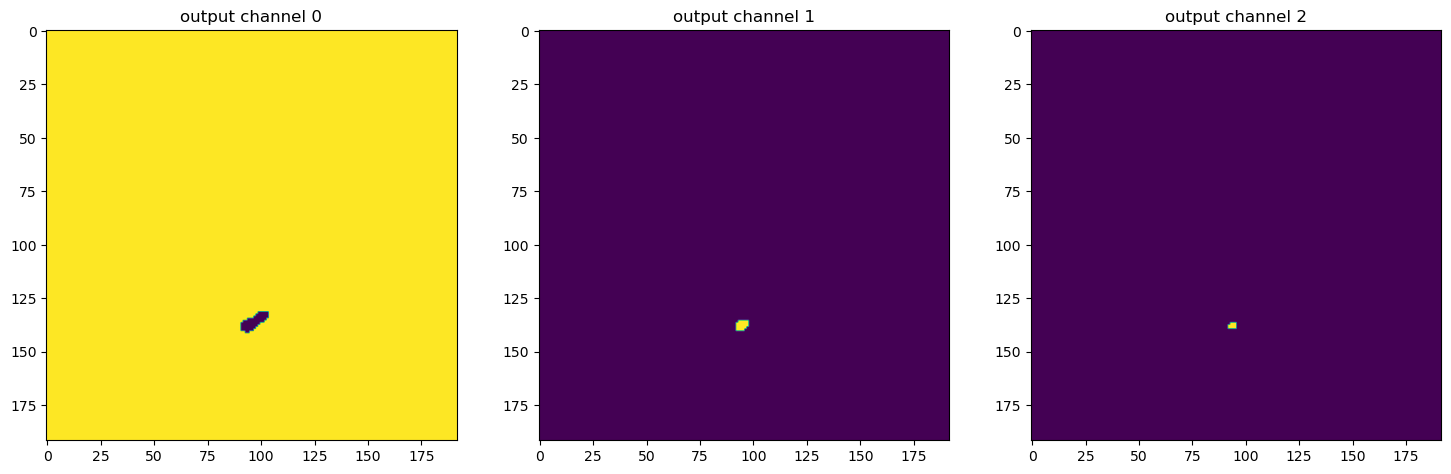

In [8]:
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_inputct = val_ds[16]["image"].unsqueeze(0).to(device)
    val_inputpt = val_ds[16]["image2"].unsqueeze(0).to(device)
    val_input = torch.concat([val_inputct, val_inputpt], axis=1)
    roi_size = (192, 192, 192)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (6, 6))
    for i in range(1):
        plt.subplot(1, 2, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[16]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[16]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

In [9]:
test_ds = CacheDataset(data=test_files, transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


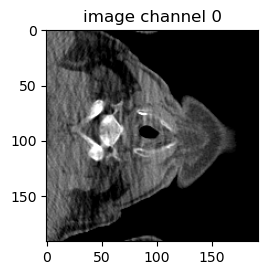

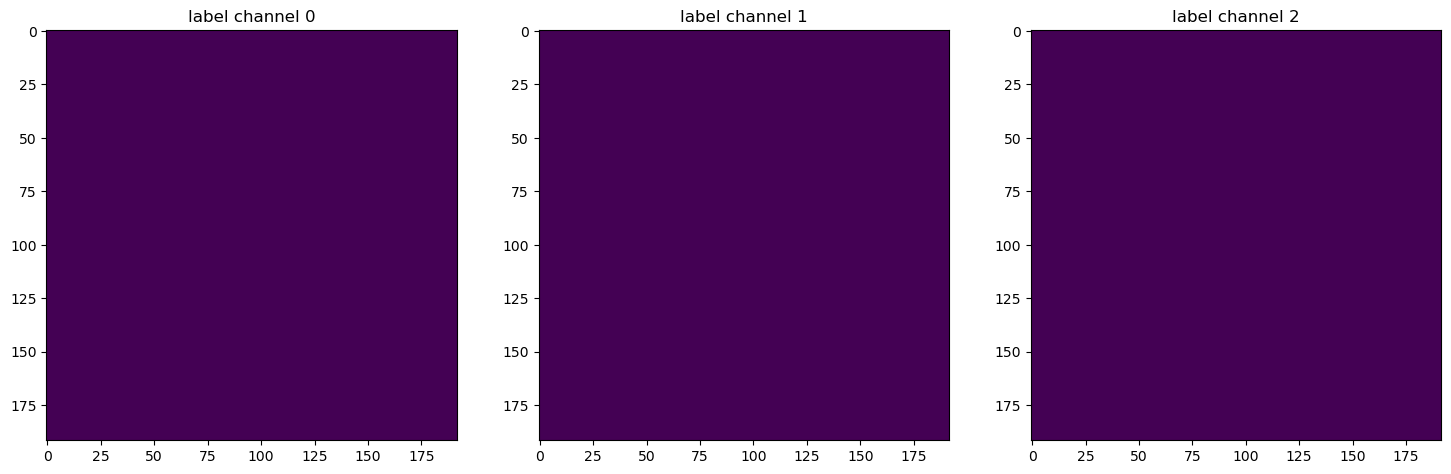

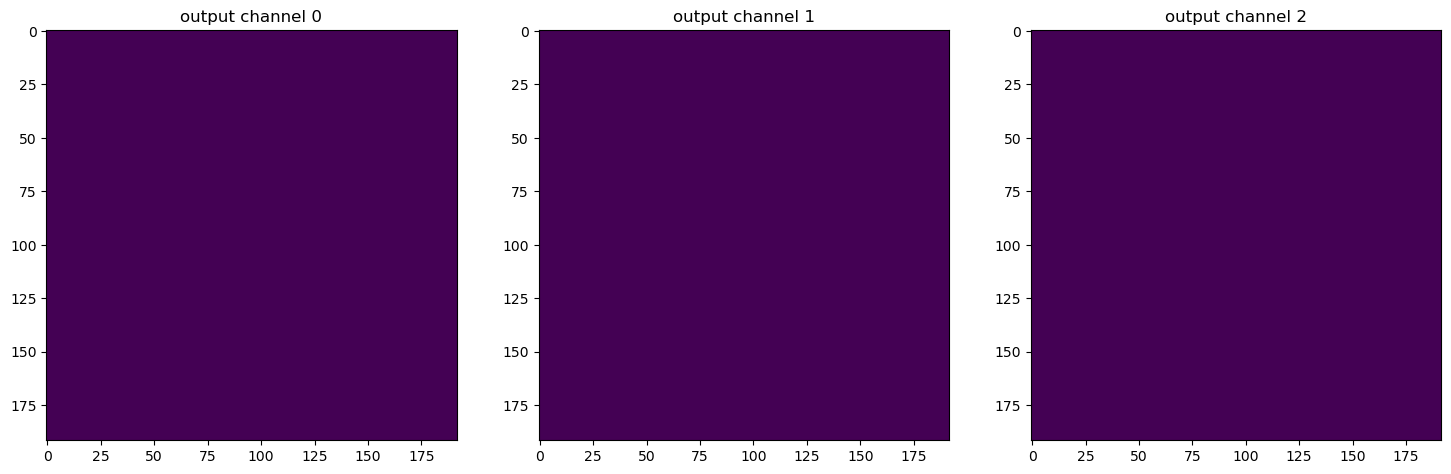

In [12]:
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_inputct = test_ds[7]["image"].unsqueeze(0).to(device)
    val_inputpt = test_ds[7]["image2"].unsqueeze(0).to(device)
    val_input = torch.concat([val_inputct, val_inputpt], axis=1)
    roi_size = (192, 192, 192)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (6, 6))
    for i in range(1):
        plt.subplot(1, 2, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(test_ds[7]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(test_ds[7]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()